# "Classify" hybrid calls (only "fused" type)

## Prerequisites

In [1]:
import os
import pandas as pd
import sys
import numpy as np
from pandas.core.common import flatten
import pickle
import umap
from pathlib import Path
import datetime
import scipy
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.legend import Legend
from matplotlib.animation import FuncAnimation
from matplotlib import animation, rc, gridspec
import matplotlib

import plotly.express as px
import plotly.graph_objects as go

import seaborn as sns
from scipy.spatial.distance import euclidean as euclid
from scipy.spatial import distance_matrix
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import datetime

from preprocessing_functions import pad_spectro, calc_zscore, create_padded_data

In [2]:
wd = os.getcwd()
DATA = os.path.join(os.path.sep, str(Path(wd).parents[0]), "data", "processed")
FIGURES = os.path.join(os.path.sep, str(Path(wd).parents[0]), "reports", "figures", "hybfu")
DF = os.path.join(os.path.sep, DATA, "meerkat_full_specs.pkl")

if (not os.path.isdir(FIGURES)):
    os.mkdir(FIGURES)
    print("Generated directory at: ",FIGURES)
else:
    print("Directory already present")

Directory already present


### Load dataset

On 03.08.2020, generated hyb/fu dataset:

In [3]:
df = pd.read_pickle(DF)

In [4]:
print("Removed unsure: ", df.shape)
df = df.loc[df['certain_yn']=="y"]
print("Removed uncertain: ",df.shape)
df = df.loc[df['nonfocal_yn']=="n"]
print("Removed nonfocal: ",df.shape)
df = df.loc[df['noisy']==0]
print("Removed noisy: ",df.shape)

df = df.loc[df.call_lable == 'fu/hyb',:]

Removed unsure:  (34955, 34)
Removed uncertain:  (34236, 34)
Removed nonfocal:  (26277, 34)
Removed noisy:  (23224, 34)


### Remove short and long calls

Text(0, 0.5, 'N. of calls')

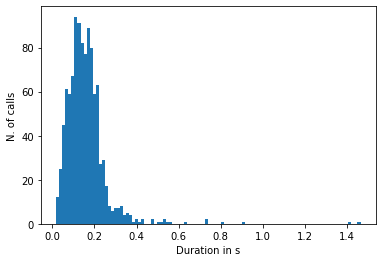

In [5]:
n, bins, pathes = plt.hist(df['duration_s'], bins=100)
plt.xlabel("Duration in s")
plt.ylabel("N. of calls")

In [6]:
MAX_DURATION = 0.5
MIN_DURATION = 0.05

print(df[df['duration_s']>MAX_DURATION].shape[0]/df.shape[0])
print(df[df['duration_s']>MAX_DURATION].shape[0])

df = df.loc[df['duration_s'] <= MAX_DURATION]
df.shape

0.011461318051575931
12


(1035, 34)

In [7]:
print(df[df['duration_s']<MIN_DURATION].shape[0]/df.shape[0]) # % of calls < 0.5s --> 9.4 %
print(df[df['duration_s']<MIN_DURATION].shape[0])

df = df.loc[df['duration_s'] >= MIN_DURATION]
df.shape

0.04057971014492753
42


(993, 34)

### Check duplicates

In [9]:
import collections

all_ids = list(df.callID.values)
duplics = [item for item, count in collections.Counter(all_ids).items() if count>1]
print(len(duplics), " duplicates found")
df[df['callID'].isin(duplics)].sort_values(by=['callID'])

0  duplicates found


,Name,Start,Duration,Time Format,Type,Description,start_s,duration_s,stop_s,date,...,raw_audio,spectrograms,denoised_spectrograms,stretched_spectrograms,stretched_denoised_spectrograms,stretched_mfccs,mfccs,zmfccs,freq_spectrograms,ampli_spectrograms


### Remove hybrids labeled as "HYB", only keep hybrids labelled as "fu" calls

In [10]:
import re

labelsep = re.compile('[\?\*\!\%\.\$]') # Match ? * ! %
clean_ambi_lables = [labelsep.sub('', i) for i in df.Name]

firstword = [i.split(' ')[0] for i in clean_ambi_lables]
pd.Series(firstword).value_counts()

fu     737
HYB    256
dtype: int64

In [11]:
df['firstword'] = firstword
df_fu = df.loc[df.firstword=="fu",:]

In [12]:
df_fu.to_pickle(os.path.join(os.path.sep, DATA, "df_fu.pkl"))

# Analysis

## UMAP project_transform

In [13]:
# Load non-hyb/fu dataset
df_clear = pd.read_pickle(os.path.join(os.path.sep, DATA, "df_focal_reduced.pkl"))
df_clear.shape

(6428, 34)

In [14]:
df_hybfu = pd.read_pickle(os.path.join(os.path.sep, DATA, "df_fu.pkl"))
df_hybfu.shape

(737, 35)

In [15]:
df_hybfu['call_lable'] = ['hyb']*df_hybfu.shape[0]

In [16]:
specs = df_clear.spectrograms.copy()
specs = [calc_zscore(x) for x in specs] 

# pad feature
maxlen= np.max([spec.shape[1] for spec in specs])
flattened_specs = [pad_spectro(spec, maxlen).flatten() for spec in specs]
data = np.asarray(flattened_specs)
data.shape

(6428, 5360)

In [17]:
n_comp = 3
#n_comp = 5

reducer = umap.UMAP(low_memory=True, n_components = n_comp, min_dist=0, random_state=2204)
umap_res = reducer.fit(data)

In [18]:
# Project hyb/fu datapoints into UMAP space:
# Thus need them padded to same length as original specs

hybfu_specs = df_hybfu.spectrograms.copy()
hybfu_specs = [calc_zscore(x) for x in hybfu_specs] 

hybfu_flattened_specs = [pad_spectro(spec, maxlen).flatten() for spec in hybfu_specs]
hybfu_data = np.asarray(hybfu_flattened_specs)
hybfu_data.shape

(737, 5360)

In [20]:
hybfu_embeddings = np.zeros((hybfu_data.shape[0],n_comp))

for i in range(hybfu_data.shape[0]):
    print('\rProcessing row ',i, end='')
    hybfu_embeddings[i,:] = umap_res.transform(hybfu_data[i:i+1,])

Processing row  736

In [21]:
np.save(os.path.join(os.path.sep,DATA,'fu_embeddings.npy'), hybfu_embeddings)

In [22]:
hybfu_embeddings = np.load(os.path.join(os.path.sep,DATA,'fu_embeddings.npy'))

## Visualize

In [23]:
embedding_non_ambi = umap_res.embedding_
embedding_ambi = hybfu_embeddings

non_ambi_labels = df_clear.call_lable.values
ambi_labelnames = df_hybfu.Name.values
embedded_list = [embedding_non_ambi[i,:] for i in range(embedding_non_ambi.shape[0])]

embedding_all = np.concatenate((embedding_non_ambi, embedding_ambi), axis=0)
labels_all = list(df_clear.call_lable.values)+list(df_hybfu.call_lable.values)

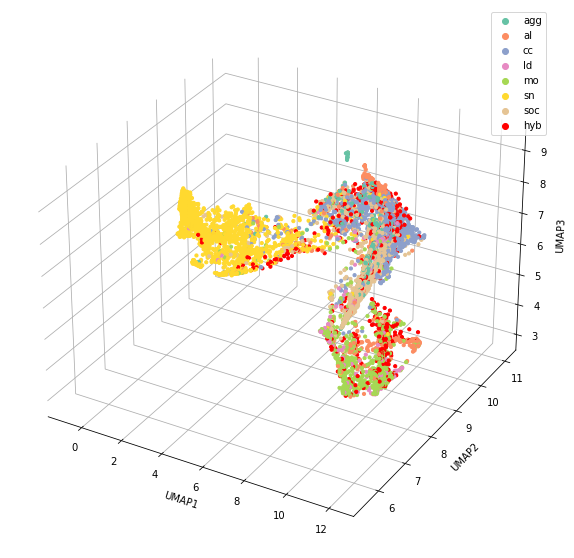

In [24]:
# https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.scatter.html#matplotlib.axes.Axes.scatter

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

scat_labels = labels_all
labeltypes = sorted(list(set(scat_labels)))

labeltypes.remove('hyb') # make these custom

# makes colors same as AVGN visualization
pal = sns.color_palette("Set2", n_colors=len(labeltypes))
#pal = sns.color_palette("deep", n_colors=len(labeltypes))
color_dict = dict(zip(labeltypes, pal))

color_dict['hyb'] = (1,0,0) # make them red

c = [color_dict[val] for val in scat_labels]


Axes3D.scatter(ax,
               xs = embedding_all[:,0],
               ys = embedding_all[:,1],
               zs = embedding_all[:,2],
               zdir='z',
               s=10,
               label = c,
               c=c,
               depthshade=False)

ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_zlabel('UMAP3')

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
    
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')

labeltypes = labeltypes+['hyb']
scatters = []
for label in labeltypes:
    scatters.append(matplotlib.lines.Line2D([0],[0], linestyle="none", c=color_dict[label], marker = 'o'))

ax.legend(scatters, labeltypes, numpoints = 1)

#plt.show()
plt.savefig(os.path.join(os.path.sep,FIGURES,datetime.datetime.today().strftime('%Y-%m-%d')+'_fu'))

In [ ]:
#def update(i, fig, ax):
#    ax.view_init(elev=20., azim=i)
#    return fig, ax
 
#anim = FuncAnimation(fig, update, frames=np.arange(0, 360, 2), repeat=True, fargs=(fig, ax))

# Save animation
#anim.save(FIGURES+datetime.datetime.today().strftime('%Y-%m-%d')+'_hybfu.gif', dpi=80, writer='pillow', fps=12)

## "Classify" fu/hyb based on k nearest neighbor

## Load dataset

In [3]:
# If starting from here: 

hybfu_classi = pd.read_pickle(os.path.join(os.path.sep, DATA,'2021-08-10_fu_classi'))

#df = pd.read_pickle(DATA+'df_denoised_balanced')
#df = df[df.nonfocal_yn == 'n'] # for focal
#df.reset_index(inplace=True)

#df = pd.read_pickle(DATA+'df_focal_hyb_fu') # wrong?
#embedding_ambi = np.load(DATA+'hybfu_embeddings.npy')

#embedding_non_ambi = pd.read_pickle(DATA+'2020-10-14_embedding_denoised_melspectro_focal')
#embedding_non_ambi = np.asarray(embedding_non_ambi)[:,0:5]

#non_ambi_labels = df.call_lable.values
#ambi_labelnames = hybfu_classi.Name.values
#embedded_list = [embedding_non_ambi[i,:] for i in range(embedding_non_ambi.shape[0])]

#hybfu_calls = hybfu_classi['hybfu_type'].map(str) + ':' + hybfu_classi['first_label'].map(str) + '_' + hybfu_classi['second_label'].map(str)
#calltypes = sorted(list(set(hybfu_classi.first_label.values)))

## Or else continue:

In [25]:
# OR IF USED PROJECT_TRANSFORM:

hybfu_classi = df_hybfu

embedding_non_ambi = umap_res.embedding_
embedding_ambi = hybfu_embeddings

non_ambi_labels = df_clear.call_lable.values
ambi_labelnames = df_hybfu.Name.values
embedded_list = [embedding_non_ambi[i,:] for i in range(embedding_non_ambi.shape[0])]

## Identify neighbors

In [26]:
from scipy.spatial.distance import euclidean as euclid
k=5

In [27]:
neighbors = []
neighbor_ids = []

for i in range(embedding_ambi.shape[0]):
    print('\rProcessing row ',i, end='')
    x = embedding_ambi[i,:]
    distances = np.asarray([euclid(x,y) for y in embedded_list])
    neighbor_inds = np.argsort(distances)[:k]
    neighbor_labels = [non_ambi_labels[ind] for ind in neighbor_inds]
    neighbors.append(neighbor_labels)
    neighbor_ids.append(neighbor_inds)

Processing row  736

In [ ]:
#hybfu_classi = df_hybfu

### Make list of hybfu labels

This is a pain to automate, because different wordings are used, sometimes there is a space between '+', sometimes not... But ok. There seems to be a systematic such that:

HYB [call1+call2]

fu call1+call2

* Remove all *,?,!, etc.
* Find out whether first word is hyb or fu
* Split everything before first space and everything after
* remove brackets in HYB
* remove all empty spaces
* split words based on +
* categorize labels according to the groups

In [28]:
import re

labelsep = re.compile('[\?\*\!\%\.\$]') # Match ? * ! %
clean_ambi_lables = [labelsep.sub('', i) for i in ambi_labelnames]

firstword = [i.split(' ')[0] for i in clean_ambi_lables]
pd.Series(firstword).value_counts()

fu    737
dtype: int64

In [29]:

clean_ambi_lables = [i.split(' ', 1)[1] for i in clean_ambi_lables]
labelsep = re.compile('[()[\]{}]') # Match brackets
clean_ambi_lables = [labelsep.sub('', i) for i in clean_ambi_lables]
faulty = [x if '+' not in x else x for x in clean_ambi_lables]

#pd.Series(faulty).value_counts()

In [30]:
clean_ambi_lables = [x+'+'+x if '+' not in x else x for x in clean_ambi_lables]

first_label = [i.split('+', 1)[0] for i in clean_ambi_lables]
second_label = [i.split('+', 1)[1] for i in clean_ambi_lables]

# Remove all non-alphabaetical
regex = re.compile('[^a-zA-Z]')

first_label = [regex.sub('', i) for i in first_label]
second_label = [regex.sub('', i) for i in second_label]

# pd.Series(first_label).value_counts()

In [31]:
call_types = {
    'cc' :["cc","Marker", "Marque", "CC", "MARKER", "MARQUE"],
    'sn' :["sn","subm", "short","^s$", "s", "SN", "SUBM", "SHORT", "S"], 
    'mo' :["mo", "mov", "move", "MO","MOV","MOVE"],
    'agg':["ag", "agg", "aggress", "chat", "growl","AG","AGG","AGGRESS","CHAT","GROWL"],
    'ld' :["ld","LD","lead","LEAD"],
    'soc':["soc","SOCIAL", "so", "SOC", "social"],
    'al' :["al", "AL","ALARM", "alarm"]#,
    #'fu/hyb': ["fu", "FU", "Fu", 'HYB', 'hyb', 'Hyb']
    }
    
# make dictionary labels to calls
labels_to_calls = dict((v,k) for k in call_types for v in call_types[k])

In [32]:
check = [lable if lable not in labels_to_calls.keys() else "recognized" for lable in first_label]
pd.Series(check).value_counts()

recognized    737
dtype: int64

In [33]:
pd.Series(second_label).value_counts()

agg         273
ld          124
s           114
soc          91
mo           68
cc           41
mov          17
al            5
cdeedrr       1
md            1
aggoragg      1
c             1
dtype: int64

In [30]:
check = [lable if lable not in labels_to_calls.keys() else "recognized" for lable in second_label]
pd.Series(check).value_counts()

recognized    733
aggoragg        1
cdeedrr         1
c               1
md              1
dtype: int64

In [34]:
first_label = [labels_to_calls[lable] if lable in labels_to_calls.keys() else "unknown" for lable in first_label]
second_label = [labels_to_calls[lable] if lable in labels_to_calls.keys() else "unknown" for lable in second_label]

In [35]:
pd.Series(second_label).value_counts()

agg        273
ld         124
sn         114
soc         91
mo          85
cc          41
al           5
unknown      4
dtype: int64

In [36]:
hybfu_calls = list(zip(firstword, first_label, second_label))

### Save dataframe

In [37]:
hybfu_classi = pd.DataFrame(list(zip(ambi_labelnames, firstword, first_label, second_label)), columns =['Name', 'hybfu_type', 'first_label', 'second_label']) 

In [38]:
for i in range(k):
    hybfu_classi['neighbor_'+str(i+1)] = [neighbor[i] for neighbor in neighbors]

In [39]:
for i in range(k):
    hybfu_classi['neighbor_id_'+str(i+1)] = [neighbor_id[i] for neighbor_id in neighbor_ids]

In [40]:
#hybfu_classi['index_id'] = df_hyb_fu['index_id']
hybfu_classi['callID'] = df_hybfu['callID'].values

In [41]:
hybfu_classi

,Name,hybfu_type,first_label,second_label,neighbor_1,neighbor_2,neighbor_3,neighbor_4,neighbor_5,neighbor_id_1,neighbor_id_2,neighbor_id_3,neighbor_id_4,neighbor_id_5,callID
0,fu cc+soc,fu,cc,soc,al,agg,al,al,sn,122,4510,128,117,291,HM_VCVM001_SOUNDFOC_20190713_1___1_05_01_660
1,fu cc+soc,fu,cc,soc,sn,al,al,sn,cc,1565,109,103,1055,5990,HM_VCVM001_SOUNDFOC_20190713_1___1_05_24_959
2,fu cc+soc,fu,cc,soc,sn,al,al,agg,sn,1255,103,109,1855,1243,HM_VCVM001_SOUNDFOC_20190713_1___1_05_26_885
3,fu cc+soc,fu,cc,soc,soc,soc,soc,soc,soc,3962,2668,2234,4152,4464,HM_VCVM001_SOUNDFOC_20190713_1___1_23_10_532
4,fu s+ld *,fu,sn,ld,soc,agg,al,al,cc,3869,1236,118,130,5722,HM_VCVM001_SOUNDFOC_20190713_1___1_47_37_696
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
732,fu mov+ld,fu,mo,ld,sn,sn,sn,sn,sn,3239,3247,3024,3375,694,HM_VHMM023_MBLS_R02_20190707-20190719_file_9_(...
733,fu cc+agg.//,fu,cc,agg,soc,soc,soc,soc,agg,2166,1476,2080,1928,2070,HM_VHMM023_MBLS_R02_20190707-20190719_file_9_(...
734,fu soc+agg *,fu,soc,agg,agg,soc,mo,soc,agg,1298,3971,4795,4358,4261,HM_VHMM023_MBLS_R02_20190707-20190719_file_9_(...
735,fu soc+agg *,fu,soc,agg,agg,al,al,al,al,4510,66,76,127,117,HM_VHMM023_MBLS_R02_20190707-20190719_file_9_(...


In [42]:
hybfu_classi['hybfu_type'] = ['hyb']*hybfu_classi.shape[0]

In [43]:
hybfu_classi.to_pickle(os.path.join(os.path.sep, DATA,'2021-08-10_fu_classi'))

# Radar charts

In [5]:
hybfu_classi = pd.read_pickle(os.path.join(os.path.sep, DATA,'2021-08-10_fu_classi'))

# hybfu_classi = pd.read_pickle(DATA+'2020-10-23_hybfu_classi_UMAP_ALL') # with all projected at once 


df = pd.read_pickle(os.path.join(os.path.sep, DATA, "df_focal_reduced.pkl"))
df.reset_index(inplace=True)
df.shape

hybfu_calls = hybfu_classi['hybfu_type'].map(str) + ':' + hybfu_classi['first_label'].map(str) + '_' + hybfu_classi['second_label'].map(str)
calltypes = sorted(list(set(hybfu_classi.first_label.values)))

In [6]:
pd.Series(hybfu_calls).value_counts()

hyb:cc_agg        236
hyb:mo_ld         102
hyb:mo_sn          92
hyb:sn_mo          70
hyb:cc_soc         51
hyb:soc_agg        35
hyb:sn_soc         32
hyb:sn_cc          26
hyb:cc_ld          16
hyb:soc_sn         13
hyb:cc_mo           9
hyb:soc_cc          7
hyb:sn_ld           6
hyb:cc_sn           6
hyb:soc_al          4
hyb:mo_cc           4
hyb:ld_mo           3
hyb:soc_mo          3
hyb:ld_cc           3
hyb:agg_soc         3
hyb:al_soc          2
hyb:sn_agg          2
hyb:al_sn           2
hyb:sn_unknown      2
hyb:mo_soc          2
hyb:cc_al           1
hyb:cc_cc           1
hyb:ld_sn           1
hyb:cc_unknown      1
hyb:soc_soc         1
hyb:mo_unknown      1
dtype: int64

In [7]:
pd.Series(hybfu_calls).value_counts()[pd.Series(hybfu_calls).value_counts()>5]

hyb:cc_agg     236
hyb:mo_ld      102
hyb:mo_sn       92
hyb:sn_mo       70
hyb:cc_soc      51
hyb:soc_agg     35
hyb:sn_soc      32
hyb:sn_cc       26
hyb:cc_ld       16
hyb:soc_sn      13
hyb:cc_mo        9
hyb:soc_cc       7
hyb:sn_ld        6
hyb:cc_sn        6
dtype: int64

Should order matter in this case? For now, keep something like fu: soc+cc and fu:cc+soc separate.

## Make charts

In [9]:
from math import pi

In [10]:
calltypes = sorted(list(set(hybfu_classi.first_label.values)))
calltypes

['agg', 'al', 'cc', 'ld', 'mo', 'sn', 'soc']

In [11]:
hybfu_calls = hybfu_classi['hybfu_type'].map(str) + ':' + hybfu_classi['first_label'].map(str) + '_' + hybfu_classi['second_label'].map(str)

In [12]:
# k=5
hybfu_classi_neighbors = np.asarray(hybfu_classi[['neighbor_1', 'neighbor_2', 'neighbor_3', 'neighbor_4', 'neighbor_5']])
label_to_index = dict(zip(calltypes,np.arange(len(calltypes))))

hybfu_neighbor_tab = np.zeros((hybfu_classi.shape[0],len(calltypes)))

for i in range(hybfu_classi.shape[0]):
    neighbors = hybfu_classi_neighbors[i,:]
    for neighbor in neighbors:
        hybfu_neighbor_tab[i,label_to_index[neighbor]] += 20

hybfu_neighbor_tab = pd.DataFrame(hybfu_neighbor_tab)
hybfu_neighbor_tab.columns = calltypes
hybfu_neighbor_tab['label'] = hybfu_calls
hybfu_neighbor_tab.head(10)

,agg,al,cc,ld,mo,sn,soc,label
0,20.0,60.0,0.0,0.0,0.0,20.0,0.0,hyb:cc_soc
1,0.0,40.0,20.0,0.0,0.0,40.0,0.0,hyb:cc_soc
2,20.0,40.0,0.0,0.0,0.0,40.0,0.0,hyb:cc_soc
3,0.0,0.0,0.0,0.0,0.0,0.0,100.0,hyb:cc_soc
4,20.0,40.0,20.0,0.0,0.0,0.0,20.0,hyb:sn_ld
5,20.0,20.0,60.0,0.0,0.0,0.0,0.0,hyb:cc_ld
6,0.0,100.0,0.0,0.0,0.0,0.0,0.0,hyb:sn_mo
7,0.0,60.0,0.0,0.0,40.0,0.0,0.0,hyb:sn_mo
8,60.0,20.0,0.0,0.0,0.0,0.0,20.0,hyb:sn_mo
9,0.0,0.0,100.0,0.0,0.0,0.0,0.0,hyb:cc_ld


In [51]:
# Optional: Normalize to overall frequencies in dataset
#overall = np.zeros((len(calltypes)))
#for i,calltype in enumerate(calltypes):
#    overall[i] = sum(df.call_lable.values==calltype)

#overall = (overall/np.sum(overall))*100

#s = hybfu_neighbor_tab.apply(lambda row : row[:-1]/overall, axis = 1) 
#s = s.replace(0,0.0001)
#hybfu_neighbor_tab_norm = np.log2(s)

#hybfu_neighbor_tab_norm['label'] = hybfu_neighbor_tab['label']

#hybfu_neighbor_tab_norm

In [52]:
# k=1
#hybfu_classi_neighbors = np.asarray(hybfu_classi[['neighbor_1', 'neighbor_2', 'neighbor_3', 'neighbor_4', 'neighbor_5']])
#label_to_index = dict(zip(calltypes,np.arange(len(calltypes))))

#hybfu_neighbor_tab = np.zeros((hybfu_classi.shape[0],len(calltypes)))

#for i in range(hybfu_classi.shape[0]):
#    neighbor = hybfu_classi_neighbors[i,1]
#    hybfu_neighbor_tab[i,label_to_index[neighbor]] += 100

#hybfu_neighbor_tab = pd.DataFrame(hybfu_neighbor_tab)
#hybfu_neighbor_tab.columns = calltypes
#hybfu_neighbor_tab['label'] = hybfu_calls
#hybfu_neighbor_tab.head(10)

In [53]:
#label_of_interest = 'fu:soc_agg'
#sub_df = hybfu_neighbor_tab.loc[hybfu_neighbor_tab['label']==label_of_interest].drop(columns='label')
#sub_df = pd.DataFrame(sub_df.mean(axis=0))
#sub_df

In [13]:
grouped = hybfu_neighbor_tab.groupby('label').mean()
#grouped = hybfu_neighbor_tab_norm.groupby('label').mean()

In [14]:
numbers = pd.DataFrame(pd.Series(hybfu_calls).value_counts())
numbers_dict = dict(zip(numbers.index, numbers.loc[:,0]))

In [15]:
# use only the ones where more than 10 datapoints are there
above_10 = [True if numbers_dict[ind]>10 else False for ind in grouped.index]
grouped_filtered = grouped.iloc[above_10,:]
grouped_filtered = grouped_filtered.reset_index()
grouped_filtered

,label,agg,al,cc,ld,mo,sn,soc
0,hyb:cc_agg,11.525424,5.847458,58.728814,0.000000,0.423729,1.949153,21.525424
1,hyb:cc_ld,3.750000,7.500000,47.500000,15.000000,10.000000,0.000000,16.250000
2,hyb:cc_soc,14.509804,7.058824,41.176471,0.784314,2.745098,2.352941,31.372549
3,hyb:mo_ld,0.000000,13.921569,4.901961,9.411765,67.254902,2.745098,1.764706
4,hyb:mo_sn,0.652174,33.695652,6.086957,8.695652,42.608696,5.652174,2.608696
5,hyb:sn_cc,4.615385,6.153846,33.076923,0.769231,6.923077,35.384615,13.076923
6,hyb:sn_mo,2.000000,32.571429,16.857143,2.571429,25.714286,15.714286,4.571429
7,hyb:sn_soc,0.625000,6.250000,10.000000,0.625000,0.625000,53.750000,28.125000
8,hyb:soc_agg,26.857143,5.142857,23.428571,0.571429,1.142857,4.000000,38.857143
9,hyb:soc_sn,13.846154,4.615385,16.923077,0.000000,0.000000,30.769231,33.846154


In [16]:
# change order of columns
grouped_filtered = grouped_filtered[['label', 'agg', 'soc', 'cc', 'ld', 'mo', 'al', 'sn']]

In [17]:
from math import pi

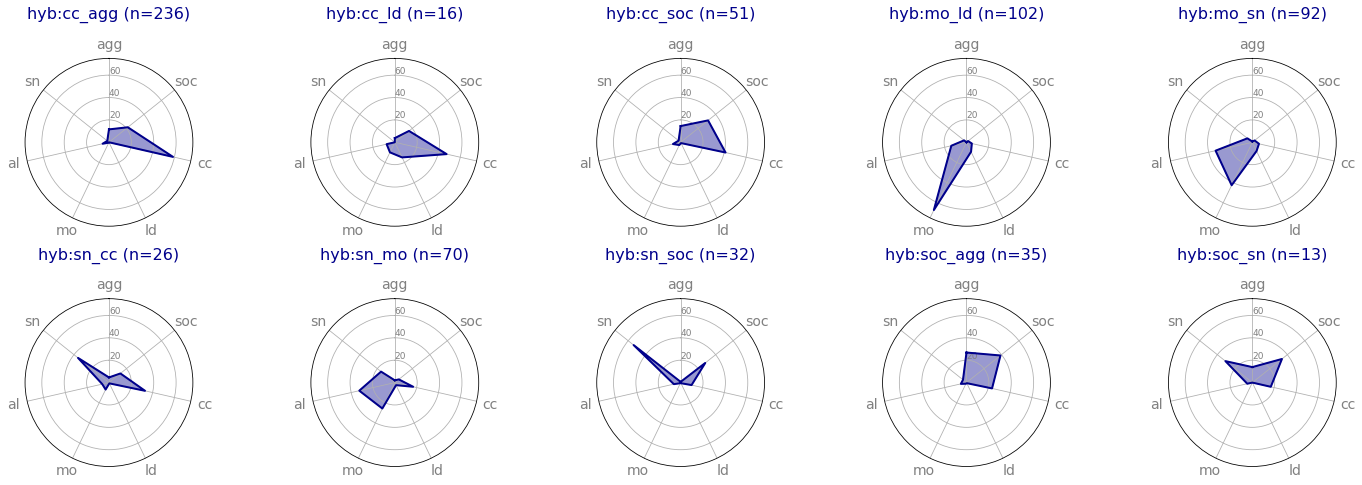

In [18]:
def make_spider(row, title, color):
    categories=list(grouped_filtered)[1:]
    N = len(categories)
  
    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
  
    # Initialise the spider plot
    #plt.figure(facecolor='white')
    
    ax = plt.subplot(3,5,row+1, polar=True, facecolor="white")
    
    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
  
    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='grey', size=14)
  
    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([20,40,60], ["20","40", "60"], color="grey", size=9)
    #plt.yticks([25,50,75], ["25","50","75"], color="grey", size=9)
    #plt.ylim(0,100)
    plt.ylim(0,75)
  
    # Ind1
    values=grouped_filtered.loc[row].drop('label').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)
    plt.title(title, size=16, color=color, y=1.2)


# initialize the figure
my_dpi=96
#plt.figure(figsize=(1000/my_dpi, 1000/my_dpi), dpi=my_dpi)
plt.figure(figsize=(20,10), facecolor="white")

# Loop to plot
for row in range(0, len(grouped_filtered.index)):
    make_spider(row=row, title=grouped_filtered['label'][row]+" (n="+str(numbers_dict[grouped_filtered['label'][row]])+")", color="darkblue")

plt.tight_layout()
#plt.savefig(os.path.join(os.path.sep, FIGURES,'fu.png'), facecolor="white")

## Paper figure

NameError: name 'labels_all' is not defined

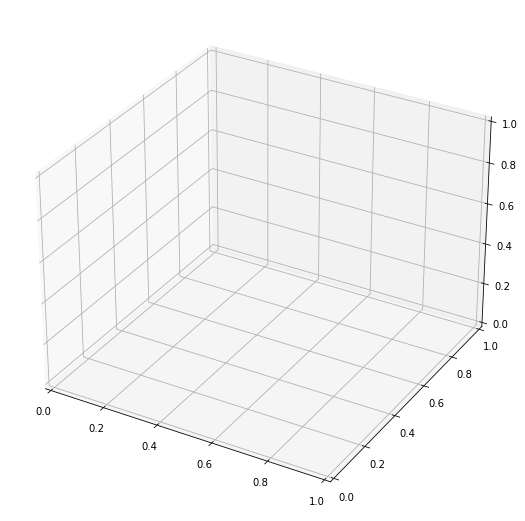

In [19]:
import string

plt.figure(figsize=(20,10), facecolor="white")
ax = plt.subplot(1,2,1, projection='3d')

scat_labels = labels_all
labeltypes = sorted(list(set(scat_labels)))

labeltypes.remove('hyb') # make these custom

# makes colors same as AVGN visualization
pal = sns.color_palette("Set2", n_colors=len(labeltypes))
color_dict = dict(zip(labeltypes, pal))
color_dict['hyb'] = (1,0,0) # make them red
c = [color_dict[val] for val in scat_labels]

Axes3D.scatter(ax,
               xs = embedding_all[:,0],
               ys = embedding_all[:,1],
               zs = embedding_all[:,2],
               zdir='z',
               s=10,
               label = c,
               c=c,
               depthshade=False)

ax.set_xlabel('UMAP1', fontsize=14)
ax.set_ylabel('UMAP2', fontsize=14)
ax.set_zlabel('UMAP3', fontsize=14)

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
    
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')

labeltypes = labeltypes+['hyb']
scatters = []
for label in labeltypes:
    scatters.append(matplotlib.lines.Line2D([0],[0], linestyle="none", c=color_dict[label], marker = 'o'))

ax.legend(scatters, labeltypes, numpoints = 1, fontsize=14)


def make_spider(r_pos, row, title, color):

    categories=list(grouped_filtered)[1:]
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    ax = plt.subplot(3,8,r_pos, polar=True)

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='grey', size=14)

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([20,40,60], ["20","40", "60"], color="grey", size=9)
    plt.ylim(0,75)

        # Ind1
    values=grouped_filtered.loc[row].drop('label').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)
    plt.title(title, size=14, color=color, y=1.2)


# Loop to plot
for row, r_pos in zip(range(0, len(grouped_filtered.index)), [5,6,7,8,13,14,15,16,21,22,23]):
    make_spider(r_pos=r_pos, row=row, title=grouped_filtered['label'][row]+" (n="+str(numbers_dict[grouped_filtered['label'][row]])+")", color="darkblue")

plt.figtext(0.01,1, "A", size=20, weight='bold')
plt.figtext(0.48,1, "B", size=20, weight='bold')
plt.tight_layout()
#plt.savefig(os.path.join(os.path.sep, FIGURES,'paper_fu.png'), facecolor="white", bbox_inches='tight')

# Evaluation

In [20]:
hybfu_type = [i.split(':')[0] for i in grouped_filtered['label']] # fu or hyb
two_labels = [i.split(':')[1] for i in grouped_filtered['label']] 
first_lab = [i.split('_')[0] for i in two_labels] # first label
second_lab = [i.split('_')[1] for i in two_labels] # second label

In [21]:
# average percentage of k nearest neighbors that belongs to either one of the hybfu labels

correct_dict={}
correct_dict['hyb'] = 0

for i in range(grouped_filtered.shape[0]):
    add_val = grouped_filtered.loc[i, first_lab[i]] + grouped_filtered.loc[i, second_lab[i]] 
    correct_dict[hybfu_type[i]] = correct_dict[hybfu_type[i]] + add_val

In [22]:
correct_dict['hyb']/np.sum(np.asarray([1 if x=='hyb' else 0 for x in hybfu_type]))

65.2325573347643

How many of the calls had neighbors of both categories?

In [23]:
hybfu_classi

,Name,hybfu_type,first_label,second_label,neighbor_1,neighbor_2,neighbor_3,neighbor_4,neighbor_5,neighbor_id_1,neighbor_id_2,neighbor_id_3,neighbor_id_4,neighbor_id_5,callID
0,fu cc+soc,hyb,cc,soc,al,agg,al,al,sn,122,4510,128,117,291,HM_VCVM001_SOUNDFOC_20190713_1___1_05_01_660
1,fu cc+soc,hyb,cc,soc,sn,al,al,sn,cc,1565,109,103,1055,5990,HM_VCVM001_SOUNDFOC_20190713_1___1_05_24_959
2,fu cc+soc,hyb,cc,soc,sn,al,al,agg,sn,1255,103,109,1855,1243,HM_VCVM001_SOUNDFOC_20190713_1___1_05_26_885
3,fu cc+soc,hyb,cc,soc,soc,soc,soc,soc,soc,3962,2668,2234,4152,4464,HM_VCVM001_SOUNDFOC_20190713_1___1_23_10_532
4,fu s+ld *,hyb,sn,ld,soc,agg,al,al,cc,3869,1236,118,130,5722,HM_VCVM001_SOUNDFOC_20190713_1___1_47_37_696
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
732,fu mov+ld,hyb,mo,ld,sn,sn,sn,sn,sn,3239,3247,3024,3375,694,HM_VHMM023_MBLS_R02_20190707-20190719_file_9_(...
733,fu cc+agg.//,hyb,cc,agg,soc,soc,soc,soc,agg,2166,1476,2080,1928,2070,HM_VHMM023_MBLS_R02_20190707-20190719_file_9_(...
734,fu soc+agg *,hyb,soc,agg,agg,soc,mo,soc,agg,1298,3971,4795,4358,4261,HM_VHMM023_MBLS_R02_20190707-20190719_file_9_(...
735,fu soc+agg *,hyb,soc,agg,agg,al,al,al,al,4510,66,76,127,117,HM_VHMM023_MBLS_R02_20190707-20190719_file_9_(...


In [24]:
hybfu_classi_neighbors = np.asarray(hybfu_classi[['neighbor_1', 'neighbor_2', 'neighbor_3', 'neighbor_4', 'neighbor_5']])
in_neighbors = [0]* hybfu_classi.shape[0]

for i in range(hybfu_classi.shape[0]):
    neighbors = hybfu_classi_neighbors[i,:]
    if ((hybfu_classi.loc[i,'first_label'] in neighbors) and (hybfu_classi.loc[i,'second_label'] in neighbors)):
        in_neighbors[i] = 1

hybfu_classi['both_in_neighbors'] = in_neighbors

In [25]:
hybfu_classi_neighbors = np.asarray(hybfu_classi[['neighbor_1', 'neighbor_2', 'neighbor_3', 'neighbor_4', 'neighbor_5']])
in_neighbors = [0]* hybfu_classi.shape[0]

for i in range(hybfu_classi.shape[0]):
    neighbors = hybfu_classi_neighbors[i,:]
    if ((hybfu_classi.loc[i,'first_label'] in neighbors) or (hybfu_classi.loc[i,'second_label'] in neighbors)):
        in_neighbors[i] = 1

hybfu_classi['any_in_neighbors'] = in_neighbors

In [26]:
from collections import Counter

pure_nbrhood = []

for i in range(hybfu_classi.shape[0]):
    words_to_count = hybfu_classi_neighbors[i,:].tolist()
    c = Counter(words_to_count)
    x= c.most_common(5)
  
    x_counts = np.asarray([x[1] for x in x])
    x_labs = np.asarray([x[0] for x in x])
    max_val = np.max(x_counts)
    if max_val==5:
        pure_nbrhood.append('yes')
    else:
        pure_nbrhood.append('no')

hybfu_classi['pure_nbrhood'] = pure_nbrhood

In [27]:
any_percent = {}
both_percent = {}
pure_percent = {}
total = {}

for selected_type in ['hyb']:
    hybfu_subset = hybfu_classi.loc[hybfu_classi['hybfu_type']==selected_type]
    
    any_percent[selected_type] = np.sum(hybfu_subset['any_in_neighbors'])/hybfu_subset.shape[0]*100
    print(selected_type, " any in neighbors:", np.sum(hybfu_subset['any_in_neighbors']), "of", hybfu_subset.shape[0], "(",np.sum(hybfu_subset['any_in_neighbors'])/hybfu_subset.shape[0], ")" )
    
    both_percent[selected_type] = np.sum(hybfu_subset['both_in_neighbors'])/hybfu_subset.shape[0]*100    
    print(selected_type, " both in neighbors:", np.sum(hybfu_subset['both_in_neighbors']), "of", hybfu_subset.shape[0], "(",np.sum(hybfu_subset['both_in_neighbors'])/hybfu_subset.shape[0], ")" )
    
    pure_percent[selected_type] = hybfu_classi.loc[(hybfu_classi['hybfu_type']==selected_type) & (hybfu_classi['pure_nbrhood']=='yes')].shape[0]/hybfu_subset.shape[0]*100
    total[selected_type] = hybfu_subset.shape[0]

hyb  any in neighbors: 644 of 737 ( 0.8738127544097694 )
hyb  both in neighbors: 183 of 737 ( 0.24830393487109906 )


### How many of the calls had majority neighbors of at least one of the two labels?

In [28]:
from collections import Counter

In [29]:
majorityvote = []

for i in range(hybfu_classi.shape[0]):
    words_to_count = hybfu_classi_neighbors[i,:].tolist()
    c = Counter(words_to_count)
    x= c.most_common(5)
  
    
    x_counts = np.asarray([x[1] for x in x])
    x_labs = np.asarray([x[0] for x in x])
    max_val = np.max(x_counts)
    selector = np.where(x_counts==max_val)[0]
    majorityvote.append(x_labs[selector])

In [30]:
in_majority = []

for i in range(hybfu_classi.shape[0]):
    if (len(majorityvote[i])>1):
        in_majority.append('tie')
    else:
        in_majority.append(majorityvote[i][0])

In [31]:
# when ties count
in_majority = []

for i in range(hybfu_classi.shape[0]):
    if (len(majorityvote[i])==2):
    # any of these in label?
        if (hybfu_classi.loc[i,'first_label'] in majorityvote[i]):
            in_majority.append(hybfu_classi.loc[i,'first_label'])
        elif (hybfu_classi.loc[i,'second_label'] in majorityvote[i]):
            in_majority.append(hybfu_classi.loc[i,'second_label'])
        else:
            in_majority.append('tie')
    elif len(majorityvote[i])>2:
        in_majority.append('tie')
    else:
        in_majority.append(majorityvote[i][0])

In [32]:
lens = [len(x) for x in majorityvote]

In [33]:
pd.Series(lens).value_counts()

1    665
2     71
5      1
dtype: int64

In [34]:
hybfu_classi['in_majority'] = in_majority
hybfu_classi['majorityvote'] = majorityvote

In [35]:
majority_in_label = []

for i in range(hybfu_classi.shape[0]):
    majority = hybfu_classi.loc[i,'in_majority']
    if majority=='tie':
        majority_in_label.append('tie')
    elif ((majority==hybfu_classi.loc[i,'first_label']) or (majority==hybfu_classi.loc[i,'second_label'])):
        majority_in_label.append('yes')
    else:
        majority_in_label.append('no')

hybfu_classi['majority_in_label'] = majority_in_label
hybfu_classi

,Name,hybfu_type,first_label,second_label,neighbor_1,neighbor_2,neighbor_3,neighbor_4,neighbor_5,neighbor_id_1,...,neighbor_id_3,neighbor_id_4,neighbor_id_5,callID,both_in_neighbors,any_in_neighbors,pure_nbrhood,in_majority,majorityvote,majority_in_label
0,fu cc+soc,hyb,cc,soc,al,agg,al,al,sn,122,...,128,117,291,HM_VCVM001_SOUNDFOC_20190713_1___1_05_01_660,0,0,no,al,[al],no
1,fu cc+soc,hyb,cc,soc,sn,al,al,sn,cc,1565,...,103,1055,5990,HM_VCVM001_SOUNDFOC_20190713_1___1_05_24_959,0,1,no,tie,"[sn, al]",tie
2,fu cc+soc,hyb,cc,soc,sn,al,al,agg,sn,1255,...,109,1855,1243,HM_VCVM001_SOUNDFOC_20190713_1___1_05_26_885,0,0,no,tie,"[sn, al]",tie
3,fu cc+soc,hyb,cc,soc,soc,soc,soc,soc,soc,3962,...,2234,4152,4464,HM_VCVM001_SOUNDFOC_20190713_1___1_23_10_532,0,1,yes,soc,[soc],yes
4,fu s+ld *,hyb,sn,ld,soc,agg,al,al,cc,3869,...,118,130,5722,HM_VCVM001_SOUNDFOC_20190713_1___1_47_37_696,0,0,no,al,[al],no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
732,fu mov+ld,hyb,mo,ld,sn,sn,sn,sn,sn,3239,...,3024,3375,694,HM_VHMM023_MBLS_R02_20190707-20190719_file_9_(...,0,0,yes,sn,[sn],no
733,fu cc+agg.//,hyb,cc,agg,soc,soc,soc,soc,agg,2166,...,2080,1928,2070,HM_VHMM023_MBLS_R02_20190707-20190719_file_9_(...,0,1,no,soc,[soc],no
734,fu soc+agg *,hyb,soc,agg,agg,soc,mo,soc,agg,1298,...,4795,4358,4261,HM_VHMM023_MBLS_R02_20190707-20190719_file_9_(...,1,1,no,soc,"[agg, soc]",yes
735,fu soc+agg *,hyb,soc,agg,agg,al,al,al,al,4510,...,76,127,117,HM_VHMM023_MBLS_R02_20190707-20190719_file_9_(...,0,1,no,al,[al],no


In [36]:
#above10_labels = pd.DataFrame(pd.Series(hybfu_calls).value_counts()[pd.Series(hybfu_calls).value_counts()>10]).index.tolist()
#selector = [True if x in above10_labels else False for x in hybfu_calls]
#hybfu_classi = hybfu_classi.loc[selector,:]

In [37]:
eval_tab = np.zeros((3,1))
for i,selected_type in enumerate(['hyb']):
    hybfu_subset = hybfu_classi[hybfu_classi['hybfu_type']==selected_type]
    print(selected_type)
    print(hybfu_subset['majority_in_label'].value_counts())
    eval_tab[:,i] = np.asarray(hybfu_subset['majority_in_label'].value_counts())
eval_tab = pd.DataFrame(eval_tab)
eval_tab.columns = ['hyb']
eval_tab.index = ['yes', 'no', 'tie']
eval_tab

hyb
yes    531
no     194
tie     12
Name: majority_in_label, dtype: int64


,hyb
yes,531.0
no,194.0
tie,12.0


In [38]:
eval_percent = eval_tab.copy()
eval_percent['hyb'] = (eval_tab['hyb'] / eval_tab['hyb'].sum()) * 100
eval_percent

,hyb
yes,72.048847
no,26.322931
tie,1.628223


In [91]:
hybfu_classi.to_pickle(os.path.join(os.path.sep,DATA,'2021-07-30-hybfu_classi'))

# Example calls

* Show examples for ties
* Show examples for clear associations
* Show nearest neighbors -> need to re-do project-transform.

In [39]:
hybfu_classi['hybfu_rownum'] = np.arange(0,hybfu_classi.shape[0],1)
hybfu_classi['hybfu_label'] = hybfu_classi['hybfu_type'].map(str) + ':' + hybfu_classi['first_label'].map(str) + '_' + hybfu_classi['second_label'].map(str)

In [40]:
df_hybfu = pd.read_pickle(os.path.join(os.path.sep, DATA, "df_fu.pkl"))
df_hybfu.reset_index(inplace=True)

In [41]:
subset = hybfu_classi.loc[hybfu_classi['in_majority']=='tie',:]

In [42]:
subset = hybfu_classi.loc[hybfu_classi['majority_in_label']=='no',:]

In [43]:
subset = hybfu_classi.loc[hybfu_classi['majority_in_label']=='yes',:]
examples = subset.sample(n=3, replace=False)
examples = examples.reset_index()
examples

,index,Name,hybfu_type,first_label,second_label,neighbor_1,neighbor_2,neighbor_3,neighbor_4,neighbor_5,...,neighbor_id_5,callID,both_in_neighbors,any_in_neighbors,pure_nbrhood,in_majority,majorityvote,majority_in_label,hybfu_rownum,hybfu_label
0,721,fu cc+agg,hyb,cc,agg,soc,cc,cc,cc,cc,...,5635,HM_VHMM023_MBLS_R02_20190707-20190719_file_7_(...,0,1,no,cc,[cc],yes,721,hyb:cc_agg
1,657,fu cc+agg,hyb,cc,agg,agg,agg,agg,agg,soc,...,4286,HM_VHMM017_RSTB_R23_20190708-20190720_file_10_...,0,1,no,agg,[agg],yes,657,hyb:cc_agg
2,260,fu s+soc *,hyb,sn,soc,sn,sn,sn,sn,sn,...,1183,HM_VHMF001_HTB_R20_20190707-20190719_file_8_(2...,0,1,yes,sn,[sn],yes,260,hyb:sn_soc


In [101]:
df.head(3)

,index,Name,Start,Duration,Time Format,Type,Description,start_s,duration_s,stop_s,...,raw_audio,spectrograms,denoised_spectrograms,stretched_spectrograms,stretched_denoised_spectrograms,stretched_mfccs,mfccs,zmfccs,freq_spectrograms,ampli_spectrograms
0,26,ALARM,1:10:56.215,0:00.178,decimal,Cue,NaN,4256.215,0.178,4256.393,...,"[0.0, 0.001953125, 0.001953125, 0.0, -0.001953...","[[-7.209921, -5.1646175, -3.098959, -2.4054718...","[[25.639555, 26.477575, 27.715773, 28.758339, ...","[[-7.1987, -6.5299683, -5.782192, -5.027586, -...","[[25.639557, 25.685383, 26.040043, 26.640596, ...","[[-191.40002, -190.285, -188.93335, -187.6061,...","[[-191.47098, -187.8111, -185.9428, -190.7444,...","[[-4.055921, -3.603153, -3.372024, -3.966035, ...","[[-4.48149, -3.8263247, -2.3380895, -0.8921968...","[[0.6477866, 0.6985383, 0.8290906, 0.97925687,..."
1,27,ALARM,1:12:04.643,0:00.317,decimal,Cue,NaN,4324.643,0.317,4324.960,...,"[-0.001953125, 0.0, -0.001953125, 0.001953125,...","[[-21.059677, -20.16883, -20.029144, -18.70754...","[[10.762169, 11.25013, 11.792789, 12.15715, 16...","[[-21.033955, -20.467411, -20.189526, -20.0539...","[[10.762169, 11.010641, 11.456001, 11.731136, ...","[[-202.38637, -201.3461, -199.93108, -198.6801...","[[-202.54906, -200.67754, -198.63663, -195.151...","[[-4.564307, -4.3215175, -4.0567517, -3.604574...","[[-14.102091, -14.716537, -15.26635, -13.70910...","[[0.114545085, 0.10672204, 0.10017597, 0.11984..."
2,28,ALARM,1:12:15.132,0:00.192,decimal,Cue,NaN,4335.132,0.192,4335.324,...,"[0.005859375, 0.005859375, 0.0078125, 0.005859...","[[-13.698711, -14.600319, -16.215317, -15.7289...","[[24.188335, 22.856678, 18.059265, 18.200275, ...","[[-13.6952095, -14.033527, -14.38166, -14.8309...","[[24.188335, 23.769962, 23.326118, 22.13004, 1...","[[-228.31644, -226.77997, -224.79376, -222.447...","[[-228.33861, -223.5106, -216.6013, -210.05571...","[[-3.8205261, -3.3101666, -2.579792, -1.887865...","[[-7.131528, -7.2517376, -7.459937, -7.4017763...","[[0.46731132, 0.46088842, 0.4499724, 0.4529955..."


In [103]:
examples.columns

Index(['Name', 'hybfu_type', 'first_label', 'second_label', 'neighbor_1',
       'neighbor_2', 'neighbor_3', 'neighbor_4', 'neighbor_5', 'neighbor_id_1',
       'neighbor_id_2', 'neighbor_id_3', 'neighbor_id_4', 'neighbor_id_5',
       'callID', 'both_in_neighbors', 'any_in_neighbors', 'pure_nbrhood',
       'in_majority', 'majorityvote', 'majority_in_label', 'hybfu_rownum',
       'hybfu_label'],
      dtype='object')

In [107]:
neighbor_rownums = [examples.loc[0,'neighbor_id_'+str(x)] for x in [1,2,3,4,5]]
neighbor_rownums
neighbor_specs = [df.loc[nb_rn, 'denoised_spectrograms'] for nb_rn in neighbor_rownums]

In [108]:
call = hybfu_classi.callID.values[0]
df_hybfu.loc[df_hybfu.callID==call,'spectrograms'].values[0]

array([[-4.9279165e+00, -4.6820564e+00, -4.4020538e+00, ...,
        -1.6309274e+00, -3.9151144e-01, -2.3841858e-07],
       [-1.2841336e+01, -1.3240724e+01, -1.4512733e+01, ...,
        -7.7616196e+00, -6.5707169e+00, -6.1702032e+00],
       [-2.3024519e+01, -2.2457771e+01, -2.2018482e+01, ...,
        -8.3669195e+00, -9.0802383e+00, -1.0259078e+01],
       ...,
       [-6.3060394e+01, -6.1016148e+01, -5.7075356e+01, ...,
        -5.9836235e+01, -6.2496784e+01, -6.5550529e+01],
       [-5.9525166e+01, -5.8393799e+01, -5.7344997e+01, ...,
        -6.0797363e+01, -6.1606415e+01, -6.1655849e+01],
       [-6.3625099e+01, -6.2152752e+01, -6.0491165e+01, ...,
        -6.0521076e+01, -5.8954498e+01, -5.8043694e+01]], dtype=float32)

In [109]:
hybfu_classi

,Name,hybfu_type,first_label,second_label,neighbor_1,neighbor_2,neighbor_3,neighbor_4,neighbor_5,neighbor_id_1,...,neighbor_id_5,callID,both_in_neighbors,any_in_neighbors,pure_nbrhood,in_majority,majorityvote,majority_in_label,hybfu_rownum,hybfu_label
0,fu cc+soc,hyb,cc,soc,al,agg,al,al,sn,122,...,291,HM_VCVM001_SOUNDFOC_20190713_1___1_05_01_660,0,0,no,al,[al],no,0,hyb:cc_soc
1,fu cc+soc,hyb,cc,soc,sn,al,al,sn,cc,1565,...,5990,HM_VCVM001_SOUNDFOC_20190713_1___1_05_24_959,0,1,no,tie,"[sn, al]",tie,1,hyb:cc_soc
2,fu cc+soc,hyb,cc,soc,sn,al,al,agg,sn,1255,...,1243,HM_VCVM001_SOUNDFOC_20190713_1___1_05_26_885,0,0,no,tie,"[sn, al]",tie,2,hyb:cc_soc
3,fu cc+soc,hyb,cc,soc,soc,soc,soc,soc,soc,3962,...,4464,HM_VCVM001_SOUNDFOC_20190713_1___1_23_10_532,0,1,yes,soc,[soc],yes,3,hyb:cc_soc
4,fu s+ld *,hyb,sn,ld,soc,agg,al,al,cc,3869,...,5722,HM_VCVM001_SOUNDFOC_20190713_1___1_47_37_696,0,0,no,al,[al],no,4,hyb:sn_ld
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
732,fu mov+ld,hyb,mo,ld,sn,sn,sn,sn,sn,3239,...,694,HM_VHMM023_MBLS_R02_20190707-20190719_file_9_(...,0,0,yes,sn,[sn],no,732,hyb:mo_ld
733,fu cc+agg.//,hyb,cc,agg,soc,soc,soc,soc,agg,2166,...,2070,HM_VHMM023_MBLS_R02_20190707-20190719_file_9_(...,0,1,no,soc,[soc],no,733,hyb:cc_agg
734,fu soc+agg *,hyb,soc,agg,agg,soc,mo,soc,agg,1298,...,4261,HM_VHMM023_MBLS_R02_20190707-20190719_file_9_(...,1,1,no,soc,"[agg, soc]",yes,734,hyb:soc_agg
735,fu soc+agg *,hyb,soc,agg,agg,al,al,al,al,4510,...,117,HM_VHMM023_MBLS_R02_20190707-20190719_file_9_(...,0,1,no,al,[al],no,735,hyb:soc_agg


In [44]:
param = 'no'
subset = hybfu_classi.loc[hybfu_classi['majority_in_label']==param,:]
examples = subset.sample(n=5, replace=False, random_state=2204)
examples
examples.index.values

array([297, 233, 117, 322, 457])

In [45]:
hybfu_classi

,Name,hybfu_type,first_label,second_label,neighbor_1,neighbor_2,neighbor_3,neighbor_4,neighbor_5,neighbor_id_1,...,neighbor_id_5,callID,both_in_neighbors,any_in_neighbors,pure_nbrhood,in_majority,majorityvote,majority_in_label,hybfu_rownum,hybfu_label
0,fu cc+soc,hyb,cc,soc,al,agg,al,al,sn,122,...,291,HM_VCVM001_SOUNDFOC_20190713_1___1_05_01_660,0,0,no,al,[al],no,0,hyb:cc_soc
1,fu cc+soc,hyb,cc,soc,sn,al,al,sn,cc,1565,...,5990,HM_VCVM001_SOUNDFOC_20190713_1___1_05_24_959,0,1,no,tie,"[sn, al]",tie,1,hyb:cc_soc
2,fu cc+soc,hyb,cc,soc,sn,al,al,agg,sn,1255,...,1243,HM_VCVM001_SOUNDFOC_20190713_1___1_05_26_885,0,0,no,tie,"[sn, al]",tie,2,hyb:cc_soc
3,fu cc+soc,hyb,cc,soc,soc,soc,soc,soc,soc,3962,...,4464,HM_VCVM001_SOUNDFOC_20190713_1___1_23_10_532,0,1,yes,soc,[soc],yes,3,hyb:cc_soc
4,fu s+ld *,hyb,sn,ld,soc,agg,al,al,cc,3869,...,5722,HM_VCVM001_SOUNDFOC_20190713_1___1_47_37_696,0,0,no,al,[al],no,4,hyb:sn_ld
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
732,fu mov+ld,hyb,mo,ld,sn,sn,sn,sn,sn,3239,...,694,HM_VHMM023_MBLS_R02_20190707-20190719_file_9_(...,0,0,yes,sn,[sn],no,732,hyb:mo_ld
733,fu cc+agg.//,hyb,cc,agg,soc,soc,soc,soc,agg,2166,...,2070,HM_VHMM023_MBLS_R02_20190707-20190719_file_9_(...,0,1,no,soc,[soc],no,733,hyb:cc_agg
734,fu soc+agg *,hyb,soc,agg,agg,soc,mo,soc,agg,1298,...,4261,HM_VHMM023_MBLS_R02_20190707-20190719_file_9_(...,1,1,no,soc,"[agg, soc]",yes,734,hyb:soc_agg
735,fu soc+agg *,hyb,soc,agg,agg,al,al,al,al,4510,...,117,HM_VHMM023_MBLS_R02_20190707-20190719_file_9_(...,0,1,no,al,[al],no,735,hyb:soc_agg


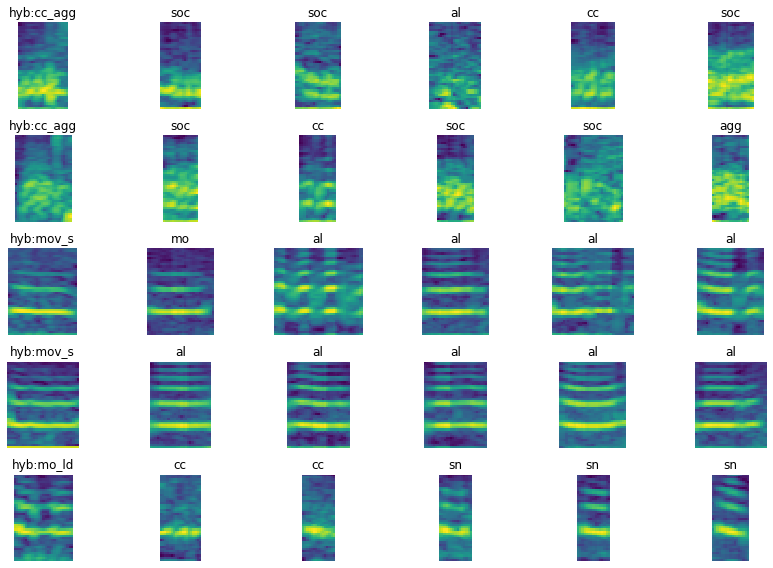

In [63]:
# Visualize examples
param = 'no'
subset = hybfu_classi.loc[hybfu_classi['majority_in_label']==param,:]
examples = subset.sample(n=5, replace=False, random_state=2204)

hybfu_rownums = examples.index.values
hybfu_specs = [df_hybfu.iloc[x, :].spectrograms for x in hybfu_rownums]
hybfu_labels = [x.replace('fu ', 'hyb:') for x in examples.Name.values]
hybfu_labels = [x.replace('+', '_') for x in hybfu_labels]
examples.reset_index(inplace=True)

plt.figure(figsize=(12, 8))
k=1
for i,hybfu_spec in enumerate(hybfu_specs):
    plt.subplot(5, 6, k)
    plt.imshow(hybfu_spec, interpolation='nearest', origin='lower', aspect='equal')
    plt.axis('off')
    plt.title(hybfu_labels[i])
    k=k+1
    neighbor_rownums = [examples.loc[i,'neighbor_id_'+str(x)] for x in [1,2,3,4,5]]
    neighbor_specs = [df.loc[nb_rn, 'denoised_spectrograms'] for nb_rn in neighbor_rownums]
    neighbor_labels = [df.loc[nb_rn, 'call_lable'] for nb_rn in neighbor_rownums]

    for nb_spec, nb_label in zip(neighbor_specs, neighbor_labels):
        plt.subplot(5, 6, k)
        plt.imshow(nb_spec, interpolation='nearest', origin='lower', aspect='equal')
        plt.title(nb_label)
        plt.axis('off') 
        k=k+1

plt.tight_layout()
#plt.savefig(os.path.join(os.path.sep,FIGURES,'mvote_'+param+'_examples.png'), facecolor="white")

In [50]:
import librosa

In [58]:
hybfu_labels

array(['fu cc+agg', 'fu cc+agg', 'fu mov+s', 'fu mov+s', 'fu mo+ld'],
      dtype=object)

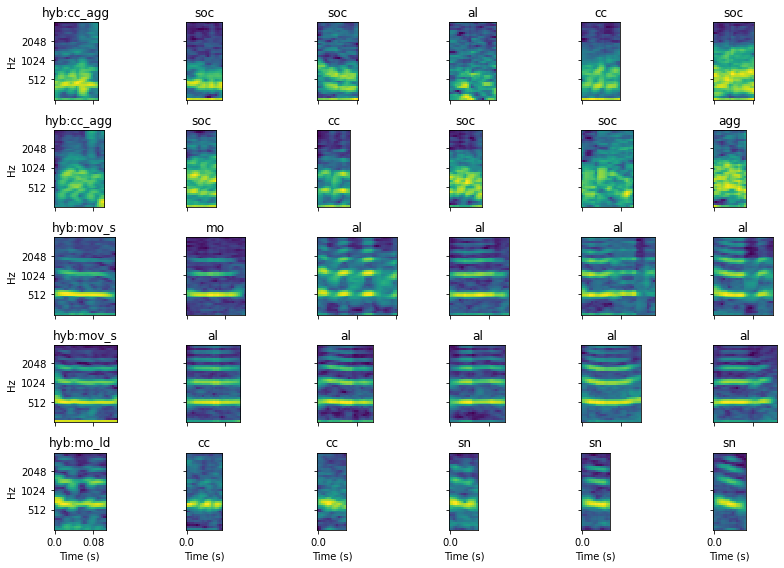

In [64]:
freq_label_list = ['512', '1024', '2048']
major_tick_interval = 20
rotate_x = 0
f_to_s = 0.00375

FFT_WIN = 0.03 # FFT_WIN*samplerate = length of fft/n_fft (number of audio frames that go in one fft)
FFT_HOP = FFT_WIN/8
ASPECT = 1

# Visualize examples
param = 'no'
subset = hybfu_classi.loc[hybfu_classi['majority_in_label']==param,:]
examples = subset.sample(n=5, replace=False, random_state=2204)

hybfu_rownums = examples.index.values
hybfu_specs = [df_hybfu.iloc[x, :].spectrograms for x in hybfu_rownums]
hybfu_srs = [df_hybfu.iloc[x, :].samplerate_hz for x in hybfu_rownums]
hybfu_labels = [x.replace('fu ', 'hyb:') for x in examples.Name.values]
hybfu_labels = [x.replace('+', '_') for x in hybfu_labels]
examples.reset_index(inplace=True)

plt.figure(figsize=(12, 8))
k=1

for i,hybfu_spec in enumerate(hybfu_specs):

    plt.subplot(5, 6, k)
    sr = hybfu_srs[i]
    
    plt.imshow(hybfu_spec, interpolation='nearest', origin='lower', aspect=ASPECT)
    ax = plt.gca()
    ax.set_anchor('W')
        
    librosa.frames_to_time(np.arange(0,hybfu_spec.shape[1],1),sr=sr, hop_length=int(FFT_HOP * sr))
        
    major_xticks = np.arange(0,hybfu_spec.shape[1], major_tick_interval) 
    major_xtick_labels = ["" for x in major_xticks]
        
    major_yticks = [10,20,30]
    major_ytick_labels = ["" for x in major_yticks]


    major_ytick_labels = freq_label_list
    plt.ylabel('Hz')
    
    if k>24:
        major_xtick_labels = [round(x*f_to_s,2) for x in major_xticks]
        plt.xlabel('Time (s)')
        
    plt.xticks(major_xticks, major_xtick_labels, rotation=rotate_x)
    plt.yticks(major_yticks, major_ytick_labels)             
    plt.title(hybfu_labels[i])
    k=k+1
    
    neighbor_rownums = [examples.loc[i,'neighbor_id_'+str(x)] for x in [1,2,3,4,5]]
    neighbor_specs = [df.loc[nb_rn, 'denoised_spectrograms'] for nb_rn in neighbor_rownums]
    neighbor_labels = [df.loc[nb_rn, 'call_lable'] for nb_rn in neighbor_rownums]
    neighbor_srs = [df.loc[nb_rn, 'samplerate_hz'] for nb_rn in neighbor_rownums]

    for nb_spec, nb_label, nb_sr in zip(neighbor_specs, neighbor_labels, neighbor_srs):
        plt.subplot(5, 6, k)
        plt.imshow(nb_spec, interpolation='nearest', origin='lower', aspect=ASPECT)
        ax = plt.gca()
        ax.set_anchor('W')
        librosa.frames_to_time(np.arange(0,nb_spec.shape[1],1),sr=nb_sr, hop_length=int(FFT_HOP * sr))
        
        major_xticks = np.arange(0,nb_spec.shape[1], major_tick_interval)  
        major_xtick_labels = ["" for x in major_xticks]
        
        major_yticks = [10,20,30]
        major_ytick_labels = ["" for x in major_yticks]
        
        if k>24:
            major_xtick_labels = [round(x*f_to_s,2) for x in major_xticks]
            plt.xlabel('Time (s)')
        
        plt.xticks(major_xticks, major_xtick_labels, rotation=rotate_x)
        plt.yticks(major_yticks, major_ytick_labels) 
        
        plt.title(nb_label)

        k=k+1

plt.tight_layout()
plt.savefig(os.path.join(os.path.sep,FIGURES,'mvote_'+param+'_examples_w_axes.png'), facecolor="white")